# Blood lead level data challenge

## The challenge

Lead poising has become a highly visible environmental health disaster. In this project, you will help decision makers use data to inform what areas or households to test for lead poising. Due to limited resources most local health departments can only test a small number of people. The goal is to help them target their testing efforts to identify the most vulnerable people to lead poisoning. 

To answer this question you need to collect lead poisoning data for a particular geography (city, state, nation, or globe). The quantity of interest is the blood lead level. You should conduct an exploratory data analysis of the data you collect keeping in mind that you want to use your analysis to make recommendations to others (thus the more granular the data the better). Some analyses might include: spatio-temporal variability, predictive modeling, unsupervised clustering, etc. You can leverage other datasets to combine with the blood lead level to support your recommendations. Provide at least one spatial or spatio-temporal visualization of your data. 


## Overview

### My approach

There has been a lot of news recently about lead poisoning in Flint, Michigan. Therefore, I chose to focus on the state of Michigan for my analysis.

The key task is to help decisionmakers determine which populations are at the highest risk of lead poisoning, as measured by a geographic region having elevated blood lead levels (blls). This task can be broken down into four parts:


>    **1. Data collection and organization**

>    **2. Data exploration and model building**

>    **3. Feature projection onto geospatial map**

>    **4. Conclusions**

This notebook will highlight the answers to these steps.

### Results summary

I pulled in US census data alongside blood lead level data on a per-zipcode basis in Michigan. I used this data to build a logistic regression classifier model that predicts whether a zipcode is at 'high risk' of lead poisoning, defined as having at least 4% of children testing positive for bll>=5ug/dL (the currently designated national safety limit, although no level is safe). The model obtained an AUC of 0.73 on held out test data. More importantly for the task at hand, I was able to set a threshold in the model that returns a true positive rate of 0.33 and a very low false positive rate of 0.02, thus identifying highly at-risk zipcodes with low false positives. The most predictive features in the model are the age of houses and poverty indicators, consistent with many previous studies. I identified zipcodes that do not have high bll's, but that my model denotes 'at risk', and should be tracked in the future. I also overlaid features from the model on a map of Michigan and showed that many zipcodes in large population centers (e.g., Detroit) have many old houses and thus are at-risk. 



## 1. Data collection and organization

### Determine what data to collect

To determine what data might be fruitful for predicting blood lead levels (bll's), I did some initial research on lead poisoning. I found that there are a number of factors that contribute to lead poisoning: 

**Major US factors:**

 * lead based paints in the walls of pre-1978 houses
 * lead water pipes 
 * lead in soil from before ban of lead-based gas
 * poverty (due to higher exposure, etc.) & ethnicity
 
**Other Major worldwide factors:**

 * car battery recycling
 * use of ceramic dishes with lead-containing glaze
 * proximity to facilities that process metals
    
I found that, despite the specific problem in Flint Michigan relating to lead from water pipes, the main source in the US of lead poisoning is paint from old houses. There was a law passed in 1978 making lead-based paints illegal to use in houses in the US. Many houses built before 1978 still have lead-based paint on their walls, and houses built before 1950 often contain a lot of lead. 

**Therefore, I determined that the most fruitful data to collect would be:**


> **1. demographic data (age, race, ethnicity, income..)**
 
 
> **2. data on characteristics of housing (age of houses, etc.)**  


I needed this data on as tight a spatial scale as possible. I found bll's on a per-zipcode basis for Michigan from the Michigan Childhood Lead Poisoning Prevention Program (CLPPP) 2014 report:

http://www.michigan.gov/documents/mdhhs/2014_Child_Lead_Testing_and_Elevated_Levels_Report_515233_7.pdf

I also needed to map the zip codes to their physical locations on a map. I used data available from the US census:

https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html

To get the demographic and housing data, I went to the US census, and downloaded relevant tables from the 2014 5-year estimate American Community Survey data:

http://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml


In all, I downloaded 22 tables, as shown here:


In [536]:
import pandas as pd
fn = '/Users/matto/Documents/censusdata/aff_download_byzip/tabledescriptions.csv'
dfnames = pd.read_csv(fn)
dfnames

,TableID,TableDescription
0,B02001,RACE
1,S1701,Poverty Status in the Past 12 Months
2,B02009,BLACK OR AFRICAN AMERICAN ALONE OR IN COMBINAT...
3,S1702,Poverty Status in the Past 12 Months of Families
4,S0101,Age and Sex
5,S1901,Income in the Past 12 Months (In 2014 Inflatio...
6,S0501,Selected Characteristics of the Native and For...
7,S2301,Employment Status
8,S0701,Geographic Mobility by Selected Characteristic...
9,S2502,Demographic Characteristics for Occupied Housi...


### Organize and filter the data

The data I had available is on a per-zipcode basis. I first mapped these Zipcodes to ZIP Code Tabulation Areas (zcta's), which are more convenient for connecting with US census data. I'll use these terms interchangeably for the sake of simplicity.

I then went through the census datasets and filtered for features that:

- were on a percent basis (e.g., percent of people in that zipcode of a certain race)


- contained percents only going up to 100 (to reduce the chance of errors)


- contained numerical values for at least 800 zipcodes (out of ~1000 total)


Because geographical proximity of zipcodes to other high-risk zipcodes might play a role in lead poisoning risk, I also created a new set of features which averaged a given feature value across the 5 zip regions closest to the given zipcode. I then filtered out zipcodes that did not have available data on bll levels.

**The final dataset contains 938 unique zipcodes and 721 features per zipcode.**



**The code to do this is below:**


#### Initial setup:

In [537]:
# imports:
from __future__ import division
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan
import seaborn as sns
import time
#import time
import pickle

#from scipy.stats import ttest_ind
#from scipy.stats import ranksums
#import statsmodels.formula.api as sm
#from functools import reduce

# for running notebook:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

## sklearn imports:
#import sklearn.linear_model
#import sklearn.cross_validation
#from sklearn.linear_model import LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
#from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer
import sklearn.linear_model as linear_model
from sklearn.cross_validation import train_test_split

#import sys
sys.path.append('/Users/matto/Documents/taxidata/')
sys.path.append('/Users/matto/Dropbox/Insight/datasciencetools/')
sys.path.append('/Users/matto/Documents/censusdata/zipcodes/cb_2014_us_zcta510_500k/')
sys.path.append('/Users/matto/Documents/censusdata/')


## set options:

# style for plots:
sns.set(style="darkgrid", color_codes=True, font_scale=1.5)

# so that i can print as many lines as i want
np.set_printoptions(threshold='nan') 

# so i can see all rows of dfs:
pd.set_option('display.max_columns', None) # 500
pd.set_option('display.max_rows', 1000)

# import proper division:
from __future__ import division

## import my toolboxes:
#import taxitools as tt
#import memorytools as mt
import datasciencetools as dst
import leadtools as lt
import geotools as gt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


####  import datasets:

processing file ACS_14_5YR_S1701_with_ann.csv...
processing file ACS_14_5YR_S1702_with_ann.csv...
processing file ACS_14_5YR_S0501_with_ann.csv...
processing file ACS_14_5YR_S1401_with_ann.csv...
processing file ACS_14_5YR_S1501_with_ann.csv...
processing file ACS_14_5YR_S1601_with_ann.csv...
processing file ACS_14_5YR_S2701_with_ann.csv...
processing file ACS_14_5YR_DP04_with_ann.csv...
Num dfl cols, pre filtering: 569
Num dfl cols, post-GEO.id2 filtering: 561
Num dfl cols, post-allnan filtering: 462
Num dfl cols, post-perc>100 filtering: 443
Histogram of # non-nans in each column of the data


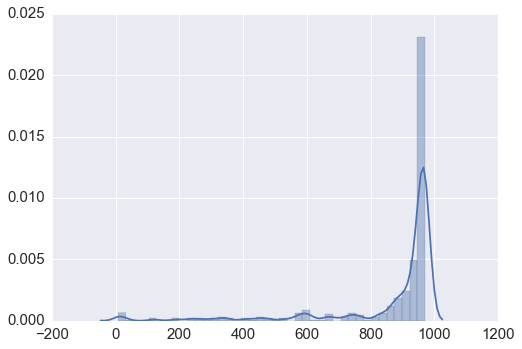

Cutoff of # non-nan values: 800
Num dfl cols, post-nan filtering: 368
Filter for nan rows in bll counts:
Rows in dfl, pre-filtering: 970 
Rows in dfl, post-filtering bll>=5 rows: 943 
Rows in dfl, post-filtering bll>=10 rows: 941 

'perc_bll_ge5' and 'perc_bll_ge10' are the lead features to predict.

Take 1 row per zcta (should combine - do later):
Rows in dfl, pre-filtering: 941 
number of unique zctas:  938
Rows in dfl, post-filtering: 938 


In [545]:
# Import lead data and census data for Michigan:
dfl, dfm = lt.build_michigan_lead_dataset(savetoFile=False)

In [546]:
# import shapes & locations of zip codes:
zctacodes, zctashapes = lt.zcta_geographies(goodcoords=[])
dfl_zctashapes, dfl_zctacenters, dfl_cities = lt.zctas_for_dfl(zctacodes, zctashapes, dfl)

In [547]:
# distances between zctas:
# slow (25 minutes), so don't do from scatch unless needed
fromScratch = False
if fromScratch:
    dfl_shapecenters, dfl_distmat = gt.build_geodist_matrix(dfl['zcta'].values, dfl_zctashapes, distmetric='haversine')
    # save the data:
    #basedir = '/Users/matto/Documents/censusdata/arnhold_challenge/'
    #pickle.dump( dfl_distmat, open( basedir + 'dfl_distmat.p', "wb" ) )
    #pickle.dump( dfl_zctashapes, open( basedir + 'dfl_zctashapes.p', "wb" ) )
    #pickle.dump( dfl_zctacenters, open( basedir + 'dfl_zctacenters.p', "wb" ) )
    #pickle.dump( dfl, open( basedir + 'dfl.p', "wb" ) )

else:
    basedir = '/Users/matto/Documents/censusdata/arnhold_challenge/'
    dfl_distmat = pickle.load( open( basedir + 'dfl_distmat.p', "rb" ) )
    dfl_zctashapes = pickle.load( open( basedir + 'dfl_zctashapes.p', "rb" ) )
    dfl_zctacenters = pickle.load( open( basedir + 'dfl_zctacenters.p', "rb" ) )
    dfl = pickle.load( open( basedir + 'dfl.p', "rb" ) )

In [548]:
# add new features to dfl based on nearby zctas:
dfl_closezctas, dfl_closezctadists = lt.find_neighboring_zctas(dfl, dfl_distmat, Nneighbors=5)
dfl, dfm = lt.build_neighboring_zcta_features(dfl, dfm, dfl_closezctas)

Note: only desc, outcode, and coltype are updated in dfm


In [560]:
print 'Number of zipcodes: ', dfl.shape[0]
print 'Number of features: ', dfl.shape[1]

Number of zipcodes:  938
Number of features:  721


In [600]:
dfl.head(3)

,zip,zcta,perc_pre1950_housing__CLPPP,children_under6__CLPPP,children_tested__CLPPP,perc_tested__CLPPP,bll_lt5__CLPPP,bll_5to9__CLPPP,capillary_ge10__CLPPP,venous_10to19__CLPPP,venous_20to44__CLPPP,venous_ge45__CLPPP,blltot_ge5__CLPPP,blltot_ge10__CLPPP,perc_bll_ge5__CLPPP,perc_bll_ge10__CLPPP,HC03_EST_VC01__S1701,HC03_EST_VC03__S1701,HC03_EST_VC04__S1701,HC03_EST_VC05__S1701,HC03_EST_VC06__S1701,HC03_EST_VC09__S1701,HC03_EST_VC10__S1701,HC03_EST_VC13__S1701,HC03_EST_VC14__S1701,HC03_EST_VC20__S1701,HC03_EST_VC22__S1701,HC03_EST_VC23__S1701,HC03_EST_VC26__S1701,HC03_EST_VC27__S1701,HC03_EST_VC28__S1701,HC03_EST_VC29__S1701,HC03_EST_VC30__S1701,HC03_EST_VC33__S1701,HC03_EST_VC34__S1701,HC03_EST_VC35__S1701,HC03_EST_VC36__S1701,HC03_EST_VC37__S1701,HC03_EST_VC38__S1701,HC03_EST_VC39__S1701,HC03_EST_VC42__S1701,HC03_EST_VC43__S1701,HC03_EST_VC44__S1701,HC03_EST_VC45__S1701,HC03_EST_VC54__S1701,HC03_EST_VC55__S1701,HC03_EST_VC56__S1701,HC03_EST_VC60__S1701,HC03_EST_VC61__S1701,HC03_EST_VC62__S1701,HC02_EST_VC01__S1702,HC04_EST_VC01__S1702,HC06_EST_VC01__S1702,HC02_EST_VC02__S1702,HC04_EST_VC02__S1702,HC06_EST_VC02__S1702,HC02_EST_VC06__S1702,HC04_EST_VC06__S1702,HC06_EST_VC06__S1702,HC02_EST_VC07__S1702,HC04_EST_VC07__S1702,HC06_EST_VC07__S1702,HC02_EST_VC16__S1702,HC04_EST_VC16__S1702,HC06_EST_VC16__S1702,HC02_EST_VC18__S1702,HC04_EST_VC18__S1702,HC06_EST_VC18__S1702,HC02_EST_VC19__S1702,HC04_EST_VC19__S1702,HC06_EST_VC19__S1702,HC02_EST_VC21__S1702,HC04_EST_VC21__S1702,HC06_EST_VC21__S1702,HC02_EST_VC23__S1702,HC04_EST_VC23__S1702,HC06_EST_VC23__S1702,HC02_EST_VC24__S1702,HC04_EST_VC24__S1702,HC06_EST_VC24__S1702,HC02_EST_VC27__S1702,HC04_EST_VC27__S1702,HC02_EST_VC28__S1702,HC04_EST_VC28__S1702,HC06_EST_VC28__S1702,HC02_EST_VC29__S1702,HC04_EST_VC29__S1702,HC06_EST_VC29__S1702,HC02_EST_VC30__S1702,HC04_EST_VC30__S1702,HC02_EST_VC33__S1702,HC04_EST_VC33__S1702,HC06_EST_VC33__S1702,HC02_EST_VC34__S1702,HC04_EST_VC34__S1702,HC06_EST_VC34__S1702,HC02_EST_VC35__S1702,HC04_EST_VC35__S1702,HC02_EST_VC39__S1702,HC04_EST_VC39__S1702,HC06_EST_VC39__S1702,HC02_EST_VC40__S1702,HC04_EST_VC40__S1702,HC06_EST_VC40__S1702,HC02_EST_VC41__S1702,HC04_EST_VC41__S1702,HC02_EST_VC45__S1702,HC04_EST_VC45__S1702,HC06_EST_VC45__S1702,HC02_EST_VC46__S1702,HC04_EST_VC46__S1702,HC06_EST_VC46__S1702,HC02_EST_VC47__S1702,HC04_EST_VC47__S1702,HC06_EST_VC47__S1702,HC02_EST_VC48__S1702,HC04_EST_VC48__S1702,HC02_EST_VC01__S1401,HC03_EST_VC01__S1401,HC02_EST_VC02__S1401,HC03_EST_VC02__S1401,HC02_EST_VC03__S1401,HC03_EST_VC03__S1401,HC02_EST_VC04__S1401,HC03_EST_VC04__S1401,HC02_EST_VC05__S1401,HC03_EST_VC05__S1401,HC02_EST_VC06__S1401,HC03_EST_VC06__S1401,HC02_EST_VC07__S1401,HC03_EST_VC07__S1401,HC02_EST_VC08__S1401,HC03_EST_VC08__S1401,HC02_EST_VC09__S1401,HC03_EST_VC09__S1401,HC01_EST_VC12__S1401,HC02_EST_VC12__S1401,HC03_EST_VC12__S1401,HC01_EST_VC13__S1401,HC02_EST_VC13__S1401,HC03_EST_VC13__S1401,HC01_EST_VC14__S1401,HC02_EST_VC14__S1401,HC03_EST_VC14__S1401,HC01_EST_VC15__S1401,HC02_EST_VC15__S1401,HC03_EST_VC15__S1401,HC01_EST_VC16__S1401,HC02_EST_VC16__S1401,HC03_EST_VC16__S1401,HC01_EST_VC17__S1401,HC02_EST_VC17__S1401,HC03_EST_VC17__S1401,HC01_EST_VC18__S1401,HC02_EST_VC18__S1401,HC03_EST_VC18__S1401,HC01_EST_VC19__S1401,HC02_EST_VC19__S1401,HC03_EST_VC19__S1401,HC02_EST_VC22__S1401,HC03_EST_VC22__S1401,HC02_EST_VC24__S1401,HC03_EST_VC24__S1401,HC02_EST_VC26__S1401,HC03_EST_VC26__S1401,HC02_EST_VC29__S1401,HC03_EST_VC29__S1401,HC02_EST_VC31__S1401,HC03_EST_VC31__S1401,HC02_EST_VC33__S1401,HC03_EST_VC33__S1401,HC01_EST_VC16__S1501,HC02_EST_VC16__S1501,HC03_EST_VC16__S1501,HC01_EST_VC17__S1501,HC02_EST_VC17__S1501,HC03_EST_VC17__S1501,HC02_EST_VC01__S1601,HC03_EST_VC01__S1601,HC02_EST_VC03__S1601,HC03_EST_VC03__S1601,HC02_EST_VC04__S1601,HC03_EST_VC04__S1601,HC02_EST_VC05__S1601,HC03_EST_VC05__S1601,HC02_EST_VC10__S1601,HC03_EST_VC10__S1601,HC02_EST_VC12__S1601,HC03_EST_VC12__S1601,HC02_EST_VC14__S1601,HC03_EST_VC14__S1601,HC02_EST_VC16__S1601,HC03_EST_

## 2. Data exploration and model building

### Choosing bll (blood lead level) feature 

My data includes multiple lead-related features from the 2014 Michigan CLPPP report:

In [570]:
print '\nData columns from the Michigan CLPPP 2014 report:\n'
dfm.loc[dfm['coltype']=='other',['desc']]


Data columns from the Michigan CLPPP 2014 report:



,desc
0,zip
1,zcta
2,perc_pre1950_housing__CLPPP
3,children_under6__CLPPP
4,children_tested__CLPPP
5,perc_tested__CLPPP
6,bll_lt5__CLPPP
7,bll_5to9__CLPPP
8,capillary_ge10__CLPPP
9,venous_10to19__CLPPP


The lead data I had access to was for children under the age of 6. The feature that seemed most appropriate to use as a standardized measure (per zipcode) of childhood bll was perc_bll_ge5, which is the percent of children below the age of 6 that tested positive for bll>5ug/dL (as a percent of all children tested within the zipcode). 

**Therefore, I used the percent bll>5ug/dL as the bll factor to predict.**

I also experimented with trying to predict the percent with bll>10ug/dL, but there was not enough data for my predictions to be robust.


### Accounting for zipcodes with few children

In initial tests, I found very strong correlations of bll with the number of children below age 6 in the data. Machine learning algorithms I ran to predict bll gave inconsistent results, and pulled up the number of young children as the most important feature every time. Removing this feature made these initial attempts at machine learning fail. Therefore, I looked at the bll's as they relate to the number of children under 6:

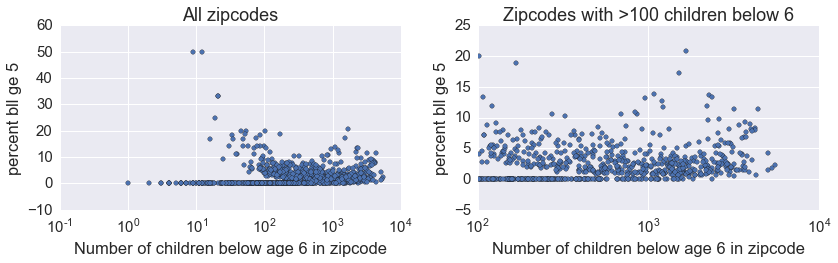

In [595]:
# remove zipcodes with <100 children under age of 6:
#sns.regplot(dfl['children_under6__CLPPP'],dfl['perc_bll_ge5__CLPPP'])
fig, ax = plt.subplots(figsize=(12,4))
ax=plt.subplot(1,2,1)    
plt.scatter(dfl['children_under6__CLPPP'],dfl['perc_bll_ge5__CLPPP'])
plt.title('All zipcodes')
plt.xlabel('Number of children below age 6 in zipcode')
plt.ylabel('percent bll ge 5')
plt.xscale('log')
ax=plt.subplot(1,2,2)    
dflcurr = dfl.loc[dfl['children_under6__CLPPP']>100,:]
plt.scatter(dflcurr['children_under6__CLPPP'],dflcurr['perc_bll_ge5__CLPPP'])
plt.title('Zipcodes with >100 children below 6')
plt.xlabel('Number of children below age 6 in zipcode')
plt.ylabel('percent bll ge 5')
plt.xscale('log')
fig.tight_layout()
plt.show()

Among zipcodes with >0% children testing positive for lead, there is a strong negative trend of the percent bll versus the number of children in the zipcode. This is especially true for zipcodes with very few children. I examined the other data from the CLPPP dataset, and could not find a way to fix this problem, which is likely an artifact of how the percentage was counted. 

**Therefore, for the remainder of the study, I eliminated zipcodes that have less than 100 children below 6 in them. This significantly improved my predictions.**

In [596]:
dfl = dfl.loc[dfl['children_under6__CLPPP']>100,:]
print 'Number of zipcodes: ', dfl.shape[0]
print 'Number of features: ', dfl.shape[1]

Number of zipcodes:  722
Number of features:  721


### Choosing an appropriate modeling framework

I considered two basic types of predictive models:

> **1. Regression models that predict % children with bll>6ug/dL**

> **2. Classification models that predict whether a zipcode is above a fixed threshold of % children with bll>6ug/dL**

**After some experimentation, I progressed with the classification task rather than the regression task.**

I chose the classification task because it includes data from all zipcodes, whereas the regression task requires first removing all zipcodes reporting zero percent of children with raised bll's (in practice, these added a lot of noise to any regression I ran). 

In [609]:
Nbll5_eq0 = dfl.loc[dfl['perc_bll_ge5__CLPPP']==0,:].shape[0]
Nbll5_gt0 = dfl.loc[dfl['perc_bll_ge5__CLPPP']>0,:].shape[0]
print "Number of zipcodes reporting that percent of children with bll>6ug/dL is 0: ", Nbll5_eq0
print "Number of zipcodes reporting that percent of children with bll>6ug/dL is greater than 0: ", Nbll5_gt0

Number of zipcodes reporting that percent of children with bll>6ug/dL is 0:  203
Number of zipcodes reporting that percent of children with bll>6ug/dL is greater than 0:  519


**Bottom line -- a classifier model can train on more data, so it should give better results.**

I tried both logistic regression and random forest classifiers, and found similar performance with either. For the sake of model interpretability, I proceeded with logistic regression. 

#### Technical methods for modeling

As a standard, I split the data 80/20 into test and training zipcodes.

I also had to deal with some missing values. I built a mean-imputer on the training data, which I then used to fill in missing values in train or test data before model training.

For modeling, I used 10-fold crossvalidation and gridsearch within the test data to choose an L1 parameter. I used L1 regularization because there are many features inputted to my model (on par with the number of observations), and it is likely that a large number of them are not predictive - L1 will help choose the most useful features and eliminate those that do not help predict bll levels. 

Finally, I report results of the model on the held out test data.

### Predicting blood lead levels

I will ask two questions below:

> **Q1. In which zipcodes are ANY children testing positive for elevated bll's?**

> **Q1. In which zipcodes are AT LEAST 4% of children testing positive for elevated bll's?**

Ultimately, we are more interested in the second answer, because we want to prioritize resources to the areas with the very highest risk levels. Therefore, the task at hand is to tune a model to work best for areas with the most risk of lead poisoning. This means that lumping zipcodes together that have less than 4 percent elevated bll's is acceptable - we are only interested in what differentiates the very unhealthy zipcodes, those with above 4% elevated bll's.

I tried higher cutoffs, but the number of zipcodes with such high bll's is low, and I ran into class imbalance problems. I also suspected that the higher cutoffs were counterproductive, since many unhealthy zipcodes were now being lumped in with the 'healthy' set. A more rigorous analysis of these cutoffs would be worth exploring given more time. 


#### Q1. which zipcodes have %bll>5ug/dL greater than 0%?

Unique values in y column: [1 0]
number of features in X: 707
True
shape of X:  (722, 707)
shape of y:  (722,)
best params: {'C': 0.01}
Features with nonzero importances:  48


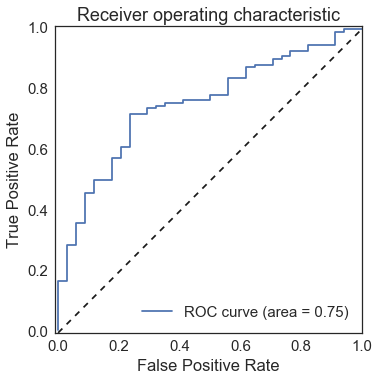

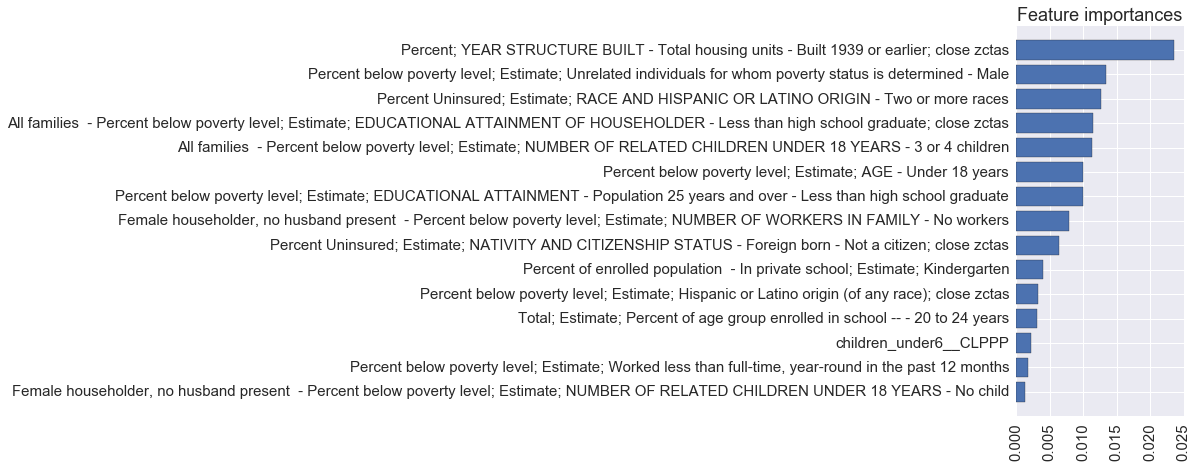

In [612]:
# create classifier y column
bllpercentcutoff = 0
dflcurr = dfl.copy()
dflcurr.loc[:,'any_bll_ge5'] = dflcurr.loc[:,'perc_bll_ge5__CLPPP']
dflcurr.loc[dflcurr['any_bll_ge5']<=bllpercentcutoff,'any_bll_ge5'] = 0
dflcurr.loc[dflcurr['any_bll_ge5']>bllpercentcutoff,'any_bll_ge5'] = 1
dflcurr.loc[:,'any_bll_ge5'] = dflcurr.loc[:,'any_bll_ge5'].astype(int)
print "Unique values in y column: %s" % dflcurr['any_bll_ge5'].unique()
print "Number of zipcodes below cutoff: ", sum(dflcurr['any_bll_ge5']==0)
print "Number of zipcodes above cutoff: ", sum(dflcurr['any_bll_ge5']==1)

# build model
outputs = lt.build_ML(dflcurr, dfm, y_name='any_bll_ge5', modelType='logisticregression', MLtype='classification')

#### Q2. which zipcodes have %bll>5ug/dL greater than 4%?

Unique values in y column: [0 1]
Number of zipcodes below cutoff:  560
Number of zipcodes above cutoff:  162
number of features in X: 707
True
shape of X:  (722, 707)
shape of y:  (722,)
best params: {'C': 0.01}
Features with nonzero importances:  44


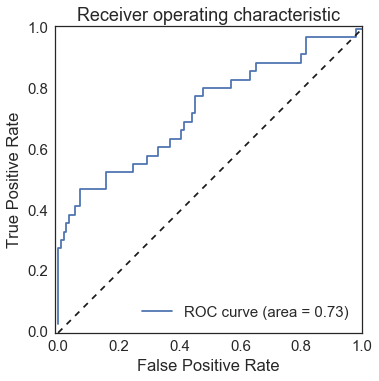

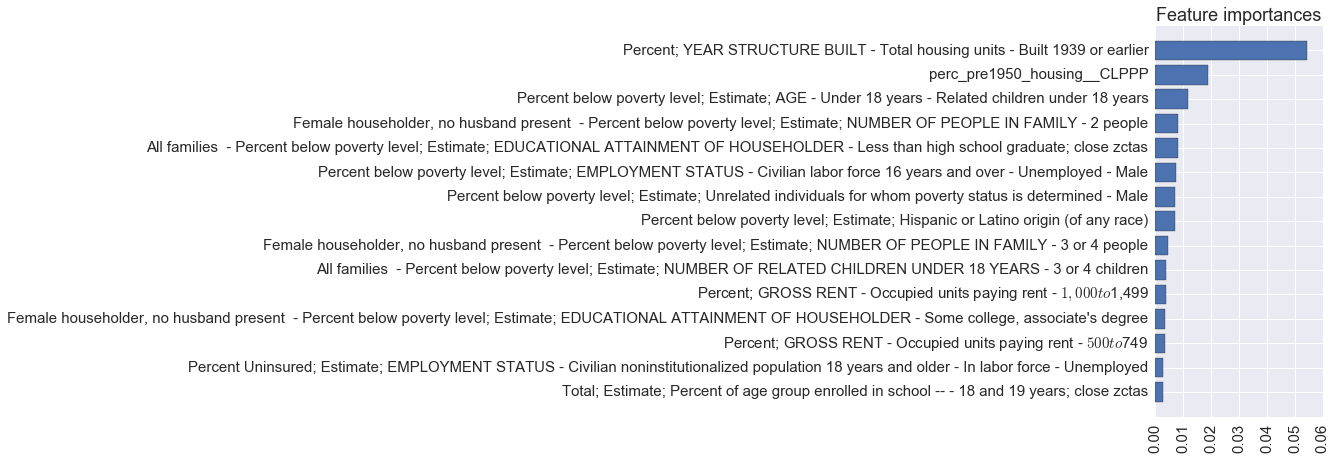

In [665]:
# create classifier y column
bllpercentcutoff = 3.9999
dflcurr = dfl.copy()
dflcurr.loc[:,'any_bll_ge5'] = dflcurr.loc[:,'perc_bll_ge5__CLPPP']
dflcurr.loc[dflcurr['any_bll_ge5']<=bllpercentcutoff,'any_bll_ge5'] = 0
dflcurr.loc[dflcurr['any_bll_ge5']>bllpercentcutoff,'any_bll_ge5'] = 1
dflcurr.loc[:,'any_bll_ge5'] = dflcurr.loc[:,'any_bll_ge5'].astype(int)
print "Unique values in y column: %s" % dflcurr['any_bll_ge5'].unique()
print "Number of zipcodes below cutoff: ", sum(dflcurr['any_bll_ge5']==0)
print "Number of zipcodes above cutoff: ", sum(dflcurr['any_bll_ge5']==1)

# build model
outputs = lt.build_ML(dflcurr, dfm, y_name='any_bll_ge5', modelType='logisticregression', MLtype='classification')

#### Observations:

The results from these models are stable across multiple runs with different test sets. There are several major observations:

> **1. Most of the most important features for predicting childhood bll's relate to percent of old houses in the zipcode and poverty levels.** 

> This is consistent with other studies, such as those cited in:
http://www.ncbi.nlm.nih.gov/pmc/articles/PMC4078581/pdf/ijerph-11-06314.pdf

> **2. Percents of pre-1939 and pre-1950 houses become more important when predicting very high bll levels (i.e., in Q2).**


> **3. The ROC curve shown in the second model (Q2) gains TPR quickly when FPR is low, meaning that a smart threshold on the model prediction confidences should be able to give confident predictions of very high risk zipcodes with few false positives.**

To elaborate on this third point, I have plotted the ROC curve again, showing both train and test data, and showing what the FPR and TPR will look like if I set a low cutoff on FPR:


Green = Train data
Blue = Test data
Red = cutoff at chosen threshold


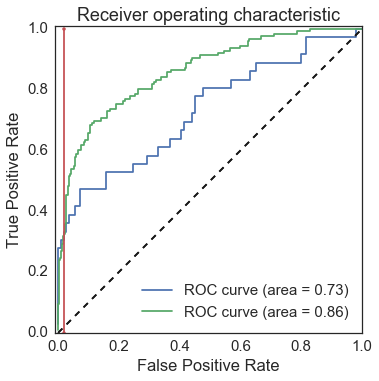

In [666]:
model, importances, X, y, X_train, X_test, y_train, y_test, X_names, y_name, y_pred_proba = outputs
y_pred_proba = model.predict_proba(X_test)[:,1]
y_pred_proba_train = model.predict_proba(X_train)[:,1]

# find best cutoff:
fprcut = 0.02
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred_proba)
bestcutoffind = max(np.where(fpr<fprcut)[0])
threshold = thresholds[bestcutoffind]
fpr_thresh = fpr[bestcutoffind]
tpr_thresh = tpr[bestcutoffind]

print "\nGreen = Train data\nBlue = Test data\nRed = cutoff at chosen threshold"
dst.plot_roc_curve(y_test, y_pred_proba, startNewPlot=False)
dst.plot_roc_curve(y_train, y_pred_proba_train, startNewPlot=False)
plt.plot([fpr_thresh, fpr_thresh],[0,1], '.r-')

plt.show()


The threshold for the logistic regression outputs defined by the red line above will ensure that FPR is very low, while maintaining a high TPR:

In [667]:
print 'false positive rate at best threshold: ', fpr_thresh
print 'true positive rate at best threshold: ', tpr_thresh

false positive rate at best threshold:  0.0183486238532
true positive rate at best threshold:  0.333333333333


This model, with the given FPR threshold, can be used to determine which zipcodes deserve the most attention.


In [689]:
# predict for all zipcodes:
y_pred_proba_all = model.predict_proba(X)[:,1]
y_pred_all = y_pred_proba_all > threshold

TP = sum((y_pred_all==y) & (y==1))
TN = sum((y_pred_all==y) & (y==0))
FP = sum((y_pred_all!=y) & (y==0))
FN = sum((y_pred_all!=y) & (y==1))

print 'Stats for predictions on all zipcodes in Michigan:'
print 'Num zipcodes correctly predicted as high-risk:   ', TP
print 'Num zipcodes correctly predicted as low-risk:    ', TN
print 'Num zipcodes incorrectly predicted as high-risk: ', FP
print 'Num zipcodes incorrectly predicted as low-risk:  ', FN
print 'FPR on all zipcodes: ', FP/(FP+TN)
print 'TPR on all zipcodes: ', TP/(FN+TP)


Stats for predictions on all zipcodes in Michigan:
Num zipcodes correctly predicted as high-risk:    52
Num zipcodes correctly predicted as low-risk:     549
Num zipcodes incorrectly predicted as high-risk:  11
Num zipcodes incorrectly predicted as low-risk:   110
FPR on all zipcodes:  0.0196428571429
TPR on all zipcodes:  0.320987654321


In [766]:
# create df of the high false positive cities:
dflcurr = dfl.copy()
FPzips = dflcurr.loc[(y_pred_all!=y) & (y==0), :]
FPzips.reset_index(drop=True)
FPcities = lt.zipcode_cities(FPzips)
FPzips.loc[:,'city'] = np.array(FPcities)

# determine top features:
topfeatures = X_names[importances>0.01]
topfeature_descs = lt.feature_descriptions(dfm, topfeatures)

# rename columns to feature names:
newcolnames = np.append(['zip','city'],topfeature_descs)
dfFP = FPzips.loc[:,np.append(['zip', 'city'],topfeatures)]
dfFP.columns = newcolnames 

print '\nZipcodes with high predicted (but not high actual) bll percent:\n'
dfFP



Zipcodes with high predicted (but not high actual) bll percent:



,zip,city,Percent below poverty level; Estimate; AGE - Under 18 years - Related children under 18 years,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1939 or earlier,perc_pre1950_housing__CLPPP
83,48126,Dearborn,56.0,33.6,54.1
137,48201,Detroit,61.0,34.6,51.0
153,48217,Detroit,60.4,24.6,56.1
154,48218,River Rouge,51.0,56.2,62.1
161,48226,Detroit,40.1,42.4,49.4
199,48341,Pontiac,45.7,30.3,46.4
200,48342,Pontiac,72.3,24.2,42.3
291,48601,Saginaw,52.9,20.5,36.4
405,48831,Elsie,25.9,41.2,52.7
603,49274,Reading,44.7,31.6,40.3


The zipcodes above were predicted to have a lead problem, but do not according to the data. These areas should still be considered high risk, and should be looked into further.

## 3. Feature projection onto geospatial map

Following on the previous analysis, I will project several features onto a map of Michigan:

In [740]:
# import shapes & locations of zip codes for the square around Michigan:
zctacodesMich, zctashapesMich = lt.zcta_geographies()

2725

#### Michigan zipcodes overlaid with percent of children with elevated bll's 

Map of Michigan, percent of children with bll>5ug/dL overlaid


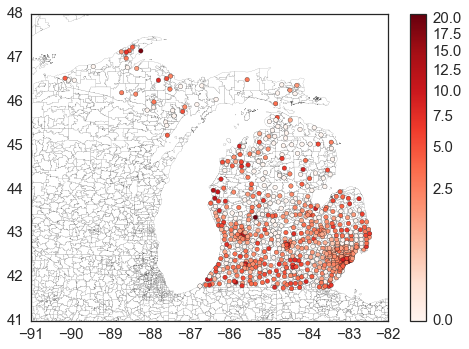

In [769]:
gt.draw_zips(zctashapesMich)
print '\nMap of Michigan, percent of children with bll>5ug/dL overlaid:'
dfl_zctashapes, dfl_zctacenters = lt.draw_zipcenters(zctacodes, zctashapes, dfl, 'perc_bll_ge5__CLPPP', gamma=0.4)
plt.show()

The above map shows Michigan, overlaid with the lead bll data. The colors correspond to percent of children within the given zipcodes that have bll>5ug/dL. I will now overlay the most predictive feature from the model, which is:

#### Michigan zipcodes overlaid with total housing units built 1939 or earlier


Map of Michigan, percent houses from before 1939 overlaid:


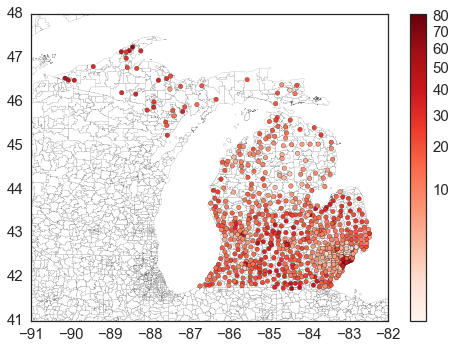

In [774]:
topfeature = X_names[importances==max(importances)]
topfeature_desc = lt.feature_descriptions(dfm, topfeature)
assert 'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1939 or earlier' == topfeature_desc[0]
gt.draw_zips(zctashapesMich)
print 'Map of Michigan, percent houses from before 1939 overlaid:'
dfl_zctashapes, dfl_zctacenters = lt.draw_zipcenters(zctacodes, zctashapes, dfl, topfeature, gamma=0.4)
plt.show()

Certain geographic centers (notably Detroit and the area around Houghton) seem to be heavily built with old houses. Special attention should be paid to these geographic regions in allocating resources.

## 4. Conclusions

In this project, I integrated US census data with blood lead level data from Michigan to build a model that predicts if children in a given zipcode are at high risk for elevated blood lead levels. 

The top 15 most predictive features are listed below, from the most predictive down:


In [804]:
# determine top features:
#topfeatures = X_names[importances>0.003]
X_descs = lt.feature_descriptions(dfm, X_names)
indices = np.argsort(importances)#[::-1]
imps_show = importances[indices][::-1][:15]
X_descs_show = X_descs[indices][::-1][:15]

pd.options.display.max_colwidth = 500
df_topfeaturedescs = pd.DataFrame({'top features':X_descs_show, 'importance':imps_show})
df_topfeaturedescs

,importance,top features
0,0.054210,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1939 or earlier
1,0.019030,perc_pre1950_housing__CLPPP
2,0.011686,Percent below poverty level; Estimate; AGE - Under 18 years - Related children under 18 years
3,0.008169,"Female householder, no husband present - Percent below poverty level; Estimate; NUMBER OF PEOPLE IN FAMILY - 2 people"
4,0.007981,All families - Percent below poverty level; Estimate; EDUCATIONAL ATTAINMENT OF HOUSEHOLDER - Less than high school graduate; close zctas
5,0.007490,Percent below poverty level; Estimate; EMPLOYMENT STATUS - Civilian labor force 16 years and over - Unemployed - Male
6,0.007168,Percent below poverty level; Estimate; Unrelated individuals for whom poverty status is determined - Male
7,0.007062,Percent below poverty level; Estimate; Hispanic or Latino origin (of any race)
8,0.004361,"Female householder, no husband present - Percent below poverty level; Estimate; NUMBER OF PEOPLE IN FAMILY - 3 or 4 people"
9,0.003867,All families - Percent below poverty level; Estimate; NUMBER OF RELATED CHILDREN UNDER 18 YEARS - 3 or 4 children


With data at higher spatial resolution than zipcode, and with more data sources such as the state of plumbing in a given region (i.e., are there lead pipes? partial pipe replacements?), I expect that a similar model to this one could prove effective in guiding healthcare workers in battling lead poisoning.



## Extra

### regression analysis

number of features in X: 707
True
shape of X:  (519, 707)
shape of y:  (519,)
R^2 for this model is: 0.396805701794


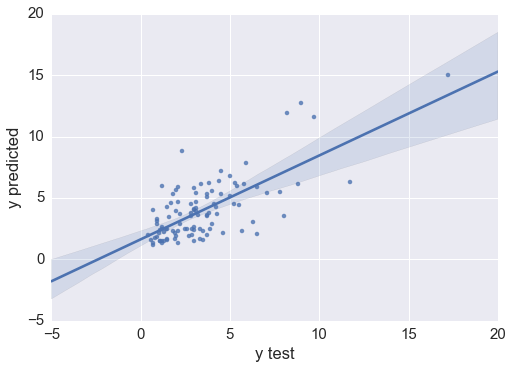

Features with nonzero importances:  336


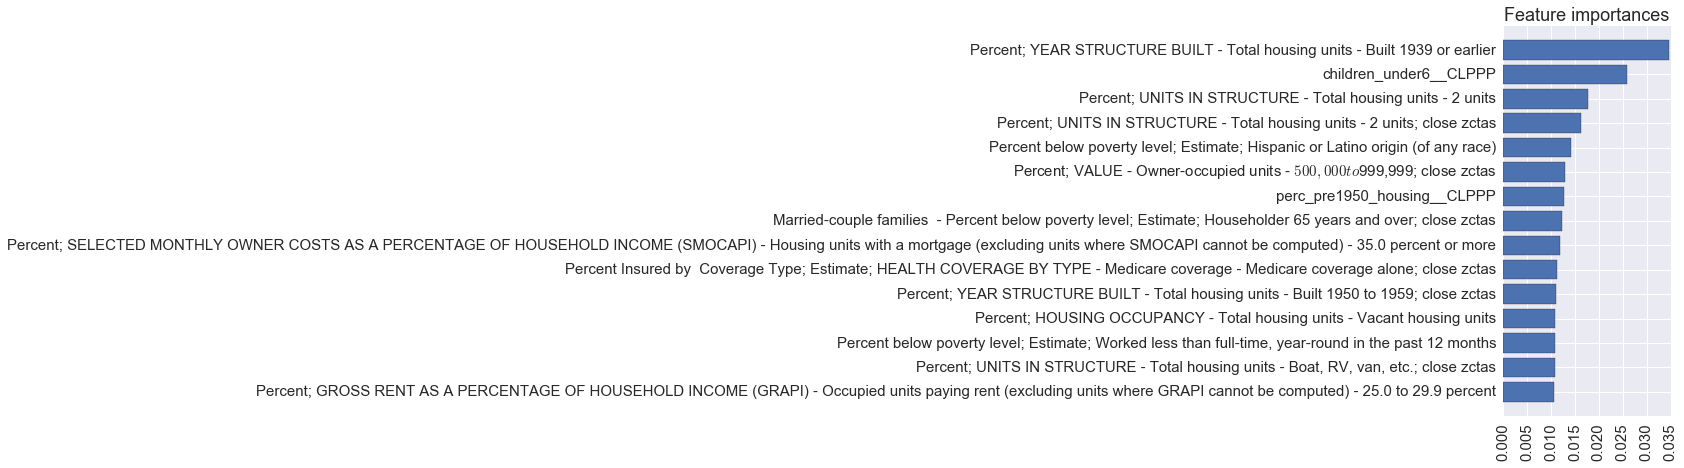

In [648]:
#  Try gradient boosting regressor (%bll>=5, only zipcodes with nonzero value):
##! need to kfold this..
# try making a smaller test set
dflcurr = dfl.loc[dfl['perc_bll_ge5__CLPPP']>0,:]
modelType = 'gradientboostregressor'
outputs = lt.build_ML(dflcurr, dfm, modelType=modelType)


number of features in X: 707
True
shape of X:  (519, 707)
shape of y:  (519,)
best params: {'n_estimators': 10, 'max_depth': None}
R^2 for this model is: 0.26206950751


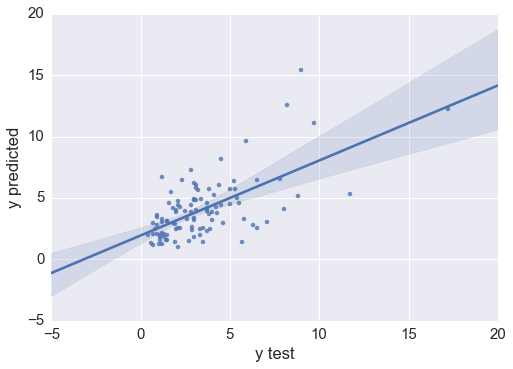

Features with nonzero importances:  674


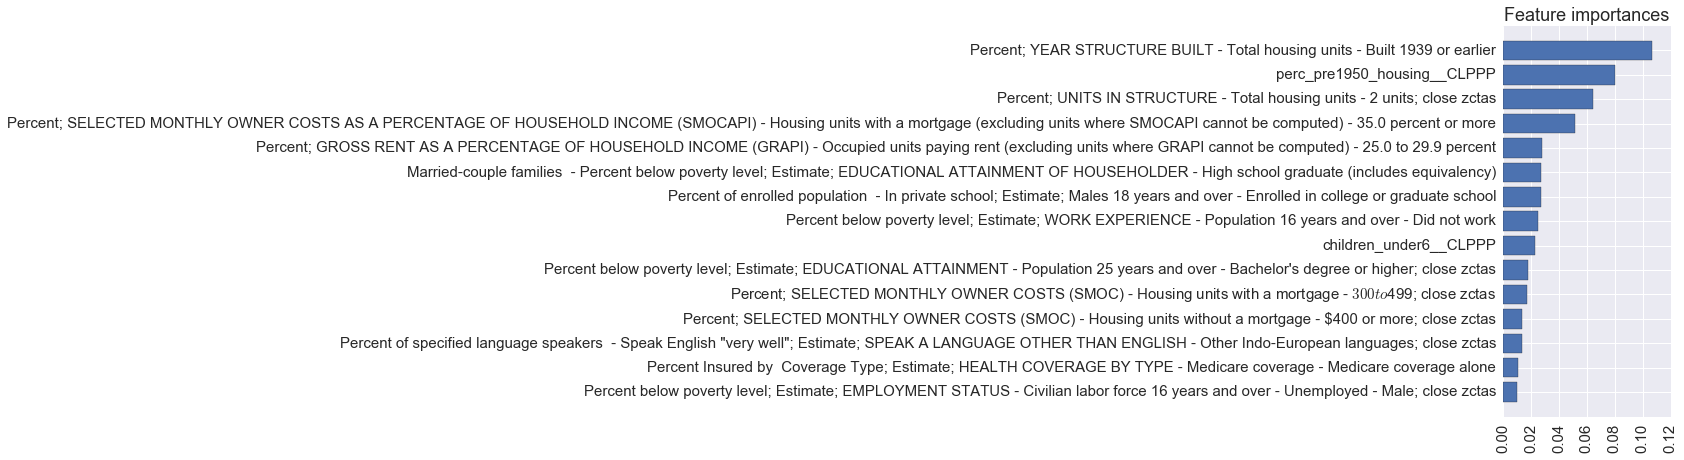

In [649]:
#  Try with random forest regressor (%bll>=5, only zipcodes with nonzero value):
##! need to kfold this..
# try making a smaller test set
dflcurr = dfl.loc[dfl['perc_bll_ge5__CLPPP']>0,:]
modelType = 'randomforestregressor'
outputs = lt.build_ML(dflcurr, dfm, modelType=modelType)


Results are not stable with different test and train sets..